In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install alphabet_detector

  Created wheel for alphabet-detector: filename=alphabet_detector-0.0.7-py3-none-any.whl size=2446 sha256=e1990b87ec7a085173a4b50cabcd2fbd3a4d3f51b04d5b02b3c02cbe5db93dac
  Stored in directory: /root/.cache/pip/wheels/22/8c/ab/4afb1765f2b8450f894a1f06c9aa2b3f8e73f2fb8b55849e17
Successfully built alphabet-detector


In [3]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 40.6 MB/s 
     |████████████████████████████████| 895 kB 38.9 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 
     |████████████████████████████████| 6.5 MB 30.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [27]:
import re
import string
import pickle

import numpy as np
import pandas as pd
import scipy.sparse
import seaborn as sns
from sklearn.model_selection import train_test_split
from alphabet_detector import AlphabetDetector
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
import transformers 
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
df = pd.read_csv("/content/drive/MyDrive/dialect_dataset.csv",lineterminator='\n')

In [7]:
df['label'].unique()

array(['IQ', 'BH', 'LY'], dtype=object)

In [8]:
df.label = df.label.apply({'IQ':0,'BH':1, "LY":2}.get)

In [23]:
class_name = ['IQ','BH','LY']

In [13]:
df.head()

,Unnamed: 0,ids,text,label
0,0,1175358310087892992,@Nw8ieJUwaCAAreT لكن بالنهاية .. ينتفض .. يغير .,0
1,1,1022409931029458944,@jolnar121 السحله ضيفي ي بتطلع لك سحليه😅😅,1
2,2,1175416117793349632,@7zNqXP0yrODdRjK يعني هذا محسوب على البشر .. ح...,0
3,3,1022430374696239232,@haneenalmwla الله يبارك فيها وبالعافيه 😋😋😋,1
4,4,1175450108898565888,@KanaanRema مبين من كلامه خليجي,0


In [9]:
arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuation(s):
    my_punctuations = string.punctuation + "،" + "؛" + "؟" + "«" + "»"
    translator = str.maketrans('', '', my_punctuations)
    return s.translate(translator)


def remove_punctuation2(s): # replace punctuation with space
    my_punctuations = string.punctuation + "،" + "؛" + "؟" + "«" + "»"
    replace_table = str.maketrans(my_punctuations,  ' '*len(my_punctuations))
    return s.translate(replace_table)

'''
def html2text(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()
'''

def remove_links(text):
    # return re.sub(r'\s*(?:https?://)?www\.\S*\.[A-Za-z]{2,5}\s*', ' ', text, flags=re.MULTILINE).strip()
    # return re.sub(r'^https?:\/\/.*[\r\n]*', '', clean_text, flags=re.MULTILINE)
    return re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE)


def remove_empty_lines(text):
    lines = [s.rstrip() for s in text.split("\n") if s.rstrip()]
    return '\n'.join(lines)


def remove_repeating_char(text):
    # return re.sub(r'(.)\1+', r'\1', text)     # keep only 1 repeat
    return re.sub(r'(.)\1+', r'\1\1', text)  # keep 2 repeat


def keep_only_arabic(text):
    ad = AlphabetDetector()
    clean_lines = list()
    for line in text.splitlines():
        clean_line = list()
        for word in line.split():
            if len(word) > 1:
                if ad.is_arabic(word):
                    if word.isalpha():
                        clean_line.append(word)
        clean_lines.append(' '.join(clean_line))
    return '\n'.join(clean_lines)


def clean_text(text):
    #text = html2text(text)
    #text = text.replace('.', '\n')
    #text = text.replace('\\', ' ')
    #text = text.replace('/', ' ')
    #text = text.replace('-', ' ')
    #text = text.replace('(', ' ')
    #text = text.replace(')', ' ')
    clean_text = remove_links(text)
    clean_text = remove_diacritics(clean_text)
    clean_text = remove_punctuation2(clean_text)
    clean_text = keep_only_arabic(clean_text)
    clean_text = remove_repeating_char(clean_text)
    clean_text = remove_empty_lines(clean_text)
    return clean_text

In [10]:
df['text'] = np.array([clean_text(text) for text in df['text']])

In [11]:
X, y = df['text'], df['label']

In [12]:
X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.2, random_state=20)

In [13]:
PRE_TRAINED_MODEL_NAME = 'UBC-NLP/MARBERT'

In [14]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/1.05M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/376 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/701 [00:00<?, ?B/s]

100%|██████████| 33768/33768 [00:20<00:00, 1649.79it/s]
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


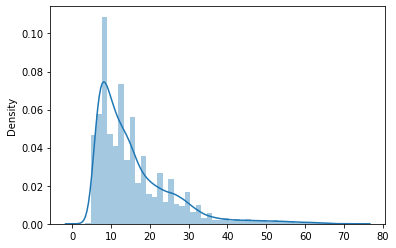

In [15]:
from tqdm import tqdm
token_lens = []
for txt in tqdm(X_train):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)

In [16]:
MAX_LEN = 35

In [17]:
class DialectDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        input = str(self.texts[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            input,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            )
        
        return {
            'input_text': input,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [ ]:
'''
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(df_train.rating.values),
                                                 df_train.rating.values)
'''                                                 

In [ ]:
#class_weights

In [31]:
def create_data_loader(x_train, y_train, tokenizer, max_len, batch_size):
    ds = DialectDataset(
        texts = x_train, 
        targets = y_train,
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size)

In [37]:
BATCH_SIZE = 32
train_data_loader = create_data_loader(list(X_train), list(y_train), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(list(X_val), list(y_val),tokenizer, MAX_LEN, BATCH_SIZE)

In [20]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/624M [00:00<?, ?B/s]

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
class DialectClassifier(nn.Module):
  def __init__(self, n_classes):
    super(DialectClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)

In [24]:
model = DialectClassifier(len(class_name))
model = model.to(device)

Some weights of the model checkpoint at UBC-NLP/MARBERT were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
EPOCHS = 3
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
#class_weights = torch.FloatTensor(class_weights).to(device)
#weight=class_weights
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()